### Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from skimage.util import montage
from IPython.display import Image, display, SVG, clear_output, HTML
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 8
plt.rcParams["font.family"] = ['sans-serif']
plt.rcParams["font.sans-serif"] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray'
def draw_graph_mpl(g, pos=None, ax=None, layout_func=nx.drawing.kamada_kawai_layout, draw_labels=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'black'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]

    edge_color = []
    edge_width = []
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'black'))
        edge_width.append(g.edges[e].get('width', 0.5))
    nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5, ax=ax)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='s', node_size=20, alpha=0.75, ax=ax)
    if draw_labels:
        nx.draw_networkx_labels(g, shift_pos, labels=node_labels, ax=ax)
    ax.autoscale()
    return fig, ax, pos

In [2]:
import numpy as np
import scipy.sparse as sp
from sklearn.neighbors import kneighbors_graph
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

MNIST_SIZE = 28
def load_data(k=8, noise_level=0.0, random_state=None):
    A = _mnist_grid_graph(k)
    if random_state is not None:
        np.random.seed(random_state)
    A = _flip_random_edges(A, noise_level).astype(np.float32)

    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train, X_test = X_train / 255., X_test / 255.
    X_train = X_train.reshape(-1, MNIST_SIZE ** 2)
    X_test = X_test.reshape(-1, MNIST_SIZE ** 2)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000,
                                                      random_state=random_state)
    return X_train, y_train, X_val, y_val, X_test, y_test, A

def _grid_coordinates(side):
    M = side ** 2
    x = np.linspace(0, 1, side, dtype=np.float32)
    y = np.linspace(0, 1, side, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    z = np.empty((M, 2), np.float32)
    z[:, 0] = xx.reshape(M)
    z[:, 1] = yy.reshape(M)
    return z

def _get_adj_from_data(X, k, **kwargs):
    A = kneighbors_graph(X, k, **kwargs).toarray()
    A = sp.csr_matrix(np.maximum(A, A.T))
    return A

def _mnist_grid_graph(k):
    X = _grid_coordinates(MNIST_SIZE)
    A = _get_adj_from_data(X, k, mode='connectivity', metric='euclidean', include_self=False)
    return A

def _flip_random_edges(A, percent):
    if not A.shape[0] == A.shape[1]:
        raise ValueError('A must be a square matrix.')
    dtype = A.dtype
    A = sp.lil_matrix(A).astype(np.bool)
    n_elem = A.shape[0] ** 2
    n_elem_to_flip = round(percent * n_elem)
    unique_idx = np.random.choice(n_elem, replace=False, size=n_elem_to_flip)
    row_idx = unique_idx // A.shape[0]
    col_idx = unique_idx % A.shape[0]
    idxs = np.stack((row_idx, col_idx)).T
    for i in idxs:
        i = tuple(i)
        A[i] = np.logical_not(A[i])
    A = A.tocsr().astype(dtype)
    A.eliminate_zeros()
    return A

### Libraries

In [3]:
from keras import Input, Model
from keras.regularizers import l2
from keras.optimizers import adam_v2
from keras.layers import Dense, Flatten

from spektral.layers import GCNConv
from spektral.utils import normalized_laplacian
from spektral.utils.sparse import sp_matrix_to_sp_tensor

In [4]:
# Load data
X_train, y_train, X_val, y_val, X_test, y_test, adj = load_data(k=8)
X_train, X_val, X_test = X_train[..., None], X_val[..., None], X_test[..., None]
N = X_train.shape[-2]
F = X_train.shape[-1]
n_out = 10
print(X_train.shape, 'model input')

D:\Anaconda\envs\graph-nx\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(50000, 784, 1) model input


### Label Nodes and Show Connections

In [5]:
xx, yy = np.meshgrid(np.arange(28), np.arange(28))
node_id = ['X:{:02d}_Y:{:02d}'.format(x, y) for x, y in zip(xx.ravel(), yy.ravel())]

print(node_id[500], 'is connected to')
for row, col in zip(*adj[500].nonzero()):
    print(col, '->', node_id[col])

X:24_Y:17 is connected to
471 -> X:23_Y:16
472 -> X:24_Y:16
473 -> X:25_Y:16
499 -> X:23_Y:17
501 -> X:25_Y:17
527 -> X:23_Y:18
528 -> X:24_Y:18
529 -> X:25_Y:18


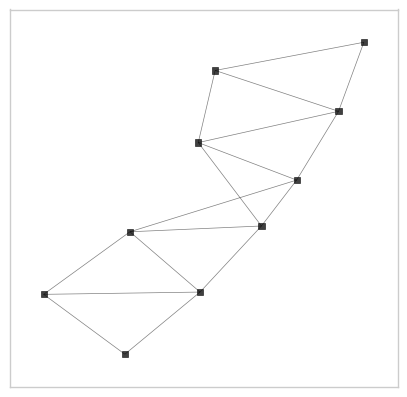

In [6]:
G = nx.from_scipy_sparse_matrix(adj[:10, :10])
for k, pix_val in zip(G.nodes, X_train[10]):
    G.nodes[k]['label'] = node_id[k]
draw_graph_mpl(G);

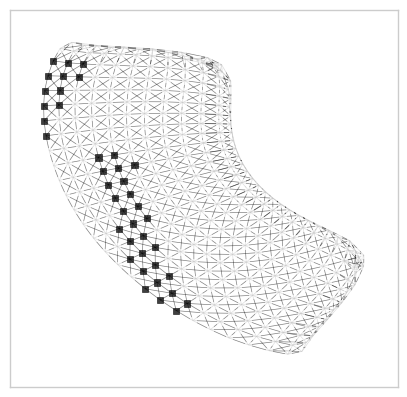

In [11]:
MAX_NODE = 28*12
G = nx.from_scipy_sparse_matrix(adj[:MAX_NODE, :MAX_NODE])
for k, pix_val in zip(G.nodes, X_train[10]):
    G.nodes[k]['label'] = node_id[k]
    G.nodes[k]['color'] = 'black' if pix_val > 0.5 else 'white'
draw_graph_mpl(G);